# Equations of motion for a "zagi-like" flying wing UAV

Do imports.

In [86]:
import numpy as np
import sympy as sym
from scipy import linalg
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
from scipy.signal import place_poles
from scipy.linalg import solve_continuous_are
from scipy.optimize import minimize

Define variables and parameters as symbols.

In [87]:
#
# VARIABLES
#

# Time
t = sym.Symbol('t', real=True)

# Components of position (meters)
p_x, p_y, p_z = sym.symbols('p_x, p_y, p_z', real=True)

# Yaw, pitch, and roll angles (radians)
psi, theta, phi = sym.symbols('psi, theta, phi', real=True)

# Components of linear velocity in the body frame (meters / second)
v_x, v_y, v_z = sym.symbols('v_x, v_y, v_z', real=True)

# Components of angular velocity in the body frame (radians / second)
w_x, w_y, w_z = sym.symbols('w_x, w_y, w_z', real=True)

# Elevon angles
delta_r, delta_l = sym.symbols('delta_r, delta_l', real=True)

#
# PARAMETERS
#

# Aerodynamic parameters
rho, S, c, b = sym.symbols('rho, S, c, b', real=True)
C_L_0, C_L_alpha, C_L_q, C_L_delta_e = sym.symbols('C_L_0, C_L_alpha, C_L_q, C_L_delta_e', real=True)
C_D_0, C_D_alpha, C_D_q, C_D_delta_e = sym.symbols('C_D_0, C_D_alpha, C_D_q, C_D_delta_e', real=True)
C_m_0, C_m_alpha, C_m_q, C_m_delta_e = sym.symbols('C_m_0, C_m_alpha, C_m_q, C_m_delta_e', real=True)
C_Y_0, C_Y_beta, C_Y_p, C_Y_r, C_Y_delta_a = sym.symbols('C_Y_0, C_Y_beta, C_Y_p, C_Y_r, C_Y_delta_a', real=True)
C_l_0, C_l_beta, C_l_p, C_l_r, C_l_delta_a = sym.symbols('C_l_0, C_l_beta, C_l_p, C_l_r, C_l_delta_a', real=True)
C_n_0, C_n_beta, C_n_p, C_n_r, C_n_delta_a = sym.symbols('C_n_0, C_n_beta, C_n_p, C_n_r, C_n_delta_a', real=True)
e, alpha_0, C_D_p, M = sym.symbols('e, alpha_0, C_D_p, M', real=True)
k, k_e = sym.symbols('k, k_e', real=True)

# Mass and inertia parameters
J_x, J_y, J_z, J_xz = sym.symbols('J_x, J_y, J_z, J_xz', real=True)
m, g = sym.symbols('m, g', real=True)

Define numerical values of parameters.

In [88]:
params = {
    g: 9.81,               # Gravity (m/s²)
    m: 1.56,               # Mass of the UAV (kg)
    J_x: 0.1147,           # Moment of inertia about x-axis (kg·m²) [UPDATED 02/28/2025]
    J_y: 0.0576,           # Moment of inertia about y-axis (kg·m²) [UPDATED 02/28/2025]
    J_z: 0.1712,           # Moment of inertia about z-axis (kg·m²) [UPDATED 02/28/2025]
    J_xz: 0.0015,          # Product of inertia (kg·m²)             [UPDATED 02/28/2025]

    S: 0.4696,             # Wing area (m²)
    b: 1.4224,             # Wingspan (m)
    c: 0.3302,             # Mean aerodynamic chord (m)

    rho: 1.2682,           # Air density (kg/m³)

    # Lift Coefficients
    C_L_0: 0.2,            # Lift coefficient at zero AoA
    C_L_alpha: 4.8,        # Lift curve slope (1/rad)
    C_L_q: 2.2,            # Pitch rate effect on lift (1/rad)

    # Drag Coefficients
    C_D_0: 0.02,           # Zero-lift drag coefficient
    C_D_alpha: 0.30,       # Drag change per AoA (1/rad)
    C_D_q: 0.0,            # Pitch rate effect on drag (1/rad)
    C_D_p: 0.03,           # Parasitic drag coefficient

    # Pitching Moment Coefficients
    C_m_0: -0.02,          # Pitching moment at zero AoA
    C_m_alpha: -0.6,       # Pitching moment change per AoA (1/rad)
    C_m_q: -1.8,           # Pitch rate effect on moment (1/rad)
    C_m_delta_e: -0.35,    # Effect of elevator deflection on pitching moment (1/rad)

    # Side Force Coefficients
    C_Y_0: 0.0,            # Side force at zero sideslip
    C_Y_beta: -0.08,       # Side force per sideslip angle (1/rad)
    C_Y_p: 0.0,            # Side force due to roll rate
    C_Y_r: 0.0,            # Side force due to yaw rate
    C_Y_delta_a: 0.0,      # Side force due to aileron deflection

    # Roll Moment Coefficients
    C_l_0: 0.0,            # Roll moment at zero sideslip
    C_l_beta: -0.10,       # Roll moment due to sideslip (1/rad)
    C_l_p: -0.45,          # Roll damping derivative (1/rad)
    C_l_r: 0.03,           # Roll moment due to yaw rate (1/rad)
    C_l_delta_a: 0.18,     # Aileron effect on roll (1/rad)

    # Yaw Moment Coefficients
    C_n_0: 0.0,            # Yaw moment at zero sideslip
    C_n_beta: 0.008,       # Yaw moment due to sideslip (1/rad)
    C_n_p: -0.022,         # Yaw moment due to roll rate (1/rad)
    C_n_r: -0.009,         # Yaw damping derivative (1/rad)
    C_n_delta_a: -0.004,   # Aileron effect on yaw (1/rad)

    # Control Derivatives
    C_L_delta_e: 0.30,     # Effect of elevator deflection on lift (1/rad)
    C_D_delta_e: 0.32,     # Effect of elevator deflection on drag (1/rad)

    # Efficiency Factors
    e: 0.85,               # Oswald efficiency factor
    alpha_0: 0.45,         # Zero-lift angle of attack (rad)

    # Additional Drag & Lift Coefficients
    M: 50.0,               # Sigmoid blending function parameter
    k_e: 0.01,             # Drag due to elevator deflection (empirical coefficient)
    k: 0.048               # Induced drag factor
}

Compute aerodynamic forces and torques (assuming low angles of attack, so no stall).

In [89]:
# Get airspeed, angle of attack, and angle of sideslip
V_a = sym.sqrt(v_x**2 + v_y**2 + v_z**2)
alpha = sym.atan(v_z / v_x)
beta = sym.asin(v_y / V_a)

# Convert from right and left elevon deflections to equivalent elevator and aileron deflections
delta_e = (delta_r + delta_l) / 2
delta_a = (-delta_r + delta_l) / 2

# Longitudinal aerodynamics
C_L = C_L_0 + C_L_alpha * alpha
F_lift = rho * V_a**2 * S * (C_L + C_L_q * (c / (2 * V_a)) * w_y + C_L_delta_e * delta_e) / 2
F_drag = rho * V_a**2 * S * ((C_D_0 + k * C_L**2) + C_D_q * (c / (2 * V_a)) * w_y + k_e * (C_L_delta_e * delta_e)**2) / 2
f_x, f_z = sym.Matrix([[sym.cos(alpha), -sym.sin(alpha)], [sym.sin(alpha), sym.cos(alpha)]]) @ sym.Matrix([[-F_drag], [-F_lift]])
tau_y = rho * V_a**2 * S * c * (C_m_0 + C_m_alpha * alpha + C_m_q * (c / (2 * V_a)) * w_y + C_m_delta_e * delta_e) / 2

# Lateral aerodynamics
f_y =   rho * V_a**2 * S *     (C_Y_0 + C_Y_beta * beta + C_Y_p * (b / (2 * V_a)) * w_x + C_Y_r * (b / (2 * V_a)) * w_z + C_Y_delta_a * delta_a) / 2
tau_x = rho * V_a**2 * S * b * (C_l_0 + C_l_beta * beta + C_l_p * (b / (2 * V_a)) * w_x + C_l_r * (b / (2 * V_a)) * w_z + C_l_delta_a * delta_a) / 2
tau_z = rho * V_a**2 * S * b * (C_n_0 + C_n_beta * beta + C_n_p * (b / (2 * V_a)) * w_x + C_n_r * (b / (2 * V_a)) * w_z + C_n_delta_a * delta_a) / 2

Define the linear velocity vector $v^B_{W, B}$ and the angular velocity vector $w^B_{W, B}$ in the coordinates of the body frame.

In [90]:
v_inB_ofWB = sym.Matrix([v_x, v_y, v_z])
w_inB_ofWB = sym.Matrix([w_x, w_y, w_z])

Define the moment of inertia matrix in the coordinates of the body frame.

In [91]:
J_inB = sym.Matrix([[  J_x,    0, -J_xz],
                    [    0,  J_y,     0],
                    [-J_xz,    0,   J_z]])

Define individual rotation matrices.

In [92]:
Rz = sym.Matrix([[sym.cos(psi), -sym.sin(psi), 0],
                 [sym.sin(psi), sym.cos(psi), 0],
                 [0, 0, 1]])

Ry = sym.Matrix([[sym.cos(theta), 0, sym.sin(theta)],
                 [0, 1, 0],
                 [-sym.sin(theta), 0, sym.cos(theta)]])

Rx = sym.Matrix([[1, 0, 0],
                 [0, sym.cos(phi), -sym.sin(phi)],
                 [0, sym.sin(phi), sym.cos(phi)]])

Apply sequential transformation to compute the rotation matrix that describes the orientation of the aircraft (i.e., of frame $B$ in the coordinates of frame $W$).

In [93]:
R_inW_ofB = Rz @ Ry @ Rx

Compute the matrix $N$ for which

$$\begin{bmatrix} \dot{\psi} \\ \dot{\theta} \\ \dot{\phi} \end{bmatrix} = N w_{W, B}^{B}.$$

In [94]:
# First, compute the inverse of N
Ninv = sym.Matrix.hstack((Ry * Rx).T * sym.Matrix([0, 0, 1]),
                              (Rx).T * sym.Matrix([0, 1, 0]),
                                       sym.Matrix([1, 0, 0]))

# Then, take the inverse of this result to compute N
N = sym.simplify(Ninv.inv())

Compute the total force and torque on the aicraft in the body frame (remember that $z$ is down!).

In [95]:
# Total force
f_inB = R_inW_ofB.T * sym.Matrix([0, 0, m * g]) + sym.Matrix([f_x, f_y, f_z])

# Total torque
tau_inB = sym.Matrix([tau_x, tau_y, tau_z])

Define (fully) symbolic equations of motion. These are complicated enough that we won't bother to show them.

In [96]:
f_sym = sym.Matrix.vstack(
    R_inW_ofB * v_inB_ofWB,
    N * w_inB_ofWB,
    (1 / m) * (f_inB - w_inB_ofWB.cross(m * v_inB_ofWB)),
    J_inB.inv() * (tau_inB - w_inB_ofWB.cross(J_inB * w_inB_ofWB)),
)

Substitute numerical values for each parameter. The only symbols that remain in these equations of motion are the (nonlinear) states and inputs. Again, these equations of motion are complicated, so we won't bother to show them. They have the following form:

$$
\begin{bmatrix} \dot{p}_x \\ \dot{p}_y \\ \dot{p}_z \\ \dot{\psi} \\ \dot{\theta} \\ \dot{\phi} \\ \dot{v}_x \\ \dot{v}_y \\ \dot{v}_z \\ \dot{w}_x \\ \dot{w}_y \\ \dot{w}_z \end{bmatrix}
=
f\left(
\begin{bmatrix} p_x \\ p_y \\ p_z \\ \psi \\ \theta \\ \phi \\ v_x \\ v_y \\ v_z \\ w_x \\ w_y \\ w_z \end{bmatrix},
\begin{bmatrix} \delta_r \\ \delta_l \end{bmatrix}
\right).
$$

In [97]:
f = f_sym.subs(params)

a = f[1:2]
b = f[3:14]
f_cut = sym.Matrix(a+b)

#display(f_cut)
#display(f) # Basically useless

In [ ]:
# Define generalized coordinates and their derivatives
m = sym.Matrix([p_y,psi, theta, phi, v_x, v_y, v_z, w_x, w_y, w_z])
mu = sym.Matrix([p_y,psi, theta, phi, v_x, v_y, v_z, w_x, w_y, w_z, delta_r, delta_l])
u = sym.Matrix([delta_r, delta_l])

xd = f_cut
An = sym.lambdify(mu,xd.jacobian([m]))
Bn = sym.lambdify(mu,xd.jacobian([u]))

A = An(0.000,  -0.000,   0.022,   0.000,   9.432,   0.000,   0.858,   0.000,   0.000,  -0.000,  -0.213,  -0.213)
B = Bn(0.000,  -0.000,   0.022,   0.000,   9.432,   0.000,   0.858,   0.000,   0.000,  -0.000,  -0.213,  -0.213)

#display(sym.Matrix(A))
#display(sym.Matrix(B))

In [112]:
def lqr(A, B, Q, R):
    P = linalg.solve_continuous_are(A, B, Q, R)
    K = linalg.inv(R) @  B.T @ P
    return K, P

#           p_y, psi, theta, phi, v_x, v_y, v_z, w_x, w_y, w_z, delta_r, delta_l
Q = np.diag([1., 1.,     1.,  1.,  2.,  10.,  5.,   1., 1., 1.])
R = np.diag([1., 1.])

K, P = lqr(A, B, Q, R)
display(sym.Matrix(K))
display(K)


Matrix([
[-0.707106781186638, -19.9489177567469,   -5.188230109985, -13.2905072675792, 0.767124793292716, -3.21719269216525, -0.461051384244452, -0.806842023887712, -0.788201722236421, -13.9309299487981],
[ 0.707106781186608,   19.948917756746, -5.18823010998499,  13.2905072675788, 0.767124793292713,   3.2171926921652,  -0.46105138424445,  0.806842023887706, -0.788201722236419,  13.9309299487974]])

array([[ -0.70710678, -19.94891776,  -5.18823011, -13.29050727,
          0.76712479,  -3.21719269,  -0.46105138,  -0.80684202,
         -0.78820172, -13.93092995],
       [  0.70710678,  19.94891776,  -5.18823011,  13.29050727,
          0.76712479,   3.21719269,  -0.46105138,   0.80684202,
         -0.78820172,  13.93092995]])

In [100]:
f_num = sym.lambdify(mu, f_cut)

# numeric solve
f_num_for_minimize = lambda x: np.linalg.norm(f_num(*x).flatten())**2

#      p_y,psi, theta,         phi, v_x, v_y, v_z, w_x, w_y, w_z, delta_r, delta_l
x0 =   [0,  0,  0.1,              0 ,  7,   0,   .2,   0,   0,   0,   -.1,       -.1] 
# the starting guess for an EQ point

sol = minimize(f_num_for_minimize, x0, tol=1e-4)

print(sol)
print('')
print(", ".join(f"{val:.3f}" for val in sol.x))


  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 6.145523000043526e-12
        x: [ 0.000e+00 -1.367e-06  1.107e-01  4.081e-07  7.033e+00
             1.029e-05  1.355e+00 -1.938e-07  8.015e-07  3.498e-07
            -3.835e-01 -3.835e-01]
      nit: 18
      jac: [ 0.000e+00  4.915e-07 -3.526e-05  4.024e-06  8.801e-07
             1.086e-06 -7.430e-06  2.858e-06 -2.929e-06 -7.956e-07
            -1.049e-05 -2.090e-05]
 hess_inv: [[ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
            [ 0.000e+00  3.657e-02 ...  1.623e-02 -1.572e-02]
            ...
            [ 0.000e+00  1.623e-02 ...  1.171e-01  4.537e-02]
            [ 0.000e+00 -1.572e-02 ...  4.537e-02  1.132e-01]]
     nfev: 338
     njev: 26

0.000, -0.000, 0.111, 0.000, 7.033, 0.000, 1.355, -0.000, 0.000, 0.000, -0.383, -0.383


In [ ]:
num_attempts = 40  # number of guesses
solutions = []

for _ in range(num_attempts):
    x0_random = np.array(x0)

    # monte carlo EQ point finding lul
    x0_random[4] = np.random.uniform(3, 11)
    x0_random[6] = np.random.uniform(0, 1)
    
    sol = minimize(f_num_for_minimize, x0_random, tol=1e-4)
    
    if sol.success:
        eq_point = sol.x
        if not any(np.linalg.norm(eq_point - s) < 1e-2 for s in solutions):  # remove duplicates
            solutions.append(eq_point)

print(f"Found {len(solutions)} unique equilibrium points.")
solutions_sorted = sorted(solutions, key=lambda x: x[4], reverse=True)

for eq_point in solutions_sorted:
    print(", ".join([f"{val:7.3f}" for val in eq_point]))  

Found 39 unique equilibrium points.
  0.000,  -0.000,  -0.023,   0.000,  11.305,   0.000,   0.573,   0.000,   0.000,  -0.000,  -0.144,  -0.144
  0.000,   0.000,  -0.020,  -0.000,  11.181,  -0.000,   0.590,  -0.000,   0.000,  -0.000,  -0.148,  -0.148
  0.000,   0.000,  -0.015,  -0.000,  10.962,  -0.000,   0.621,   0.000,   0.000,  -0.000,  -0.154,  -0.154
  0.000,  -0.000,  -0.007,  -0.000,  10.587,   0.000,   0.675,   0.000,   0.000,  -0.000,  -0.166,  -0.166
  0.000,  -0.000,  -0.007,  -0.000,  10.561,  -0.000,   0.678,  -0.000,   0.000,  -0.000,  -0.167,  -0.167
  0.000,  -0.000,  -0.006,  -0.000,  10.529,   0.000,   0.683,   0.000,   0.000,  -0.000,  -0.168,  -0.168
  0.000,   0.000,   0.005,  -0.000,  10.097,  -0.000,   0.749,  -0.000,   0.000,  -0.000,  -0.184,  -0.184
  0.000,   0.000,   0.007,  -0.000,   9.978,  -0.000,   0.768,  -0.000,   0.000,  -0.000,  -0.189,  -0.189
  0.000,  -0.000,   0.012,  -0.000,   9.783,  -0.000,   0.799,  -0.000,   0.000,  -0.000,  -0.197,  -0.197
 

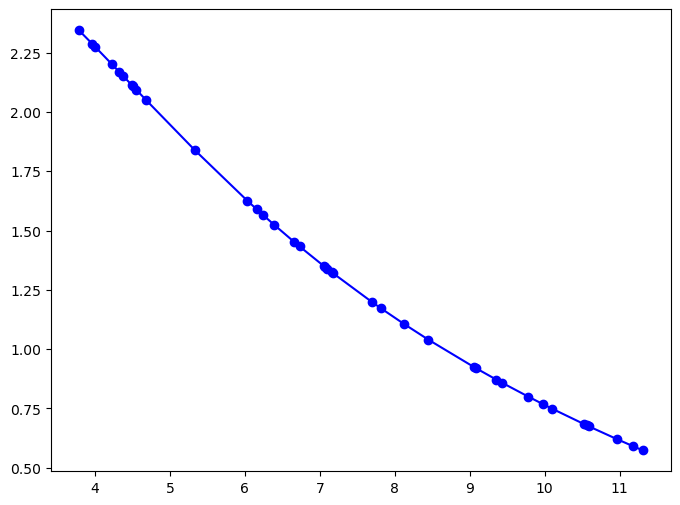

In [ ]:
v_x_vals = [eq_point[4] for eq_point in solutions_sorted]
v_y_vals = [eq_point[6] for eq_point in solutions_sorted]

plt.figure(figsize=(8, 6))

plt.plot(v_x_vals, v_y_vals, marker='o', linestyle='-', color='b')


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import ae353_zagi

# Create an instance of the simulator with display disabled
simulator = ae353_zagi.Simulator(display=False)

# Define the controller
class Controller:
    def __init__(self):
        pass
    
    def reset(self):
        pass
    
    def run(self, t, p_x, p_y, p_z, psi, theta, phi, v_x, v_y, v_z, w_x, w_y, w_z):
        # State feedback gain matrix
        K = np.array(
            [[-0.7071067811866092, -21.602054309256516, -4.565990343918835, -14.102121224883133, 0.4754289309020085, -3.2784129568395675, -1.137152279834266, -0.7834206400782244, -0.8029239895966876, -12.743148431934118], [0.7071067811865213, 21.60205430925393, -4.5659903439188225, 14.102121224882067, 0.47542893090201505, 3.278412956839427, -1.1371522798342677, 0.7834206400782118, -0.8029239895966852, 12.743148431932385]]

        )
        
        # State vector
        x = np.array([[p_y, psi, theta, phi, v_x, v_y, v_z, w_x, w_y, w_z]]).T

        # Compute control input
        x_d = -K @ x
        delta_r = x_d[0][0]  # Right elevon deflection angle (positive is down)
        delta_l = x_d[1][0]  # Left elevon deflection angle (positive is down)
        
        return delta_r, delta_l

# Create an instance of the controller
controller = Controller()

# Run multiple simulations and count landings
num_simulations = 100
successful_landings = 0
failed_landings = 0

for i in range(num_simulations):
    simulator.reset()  # Reset simulator with random initial conditions
    controller.reset()  # Reset controller
    
    # Run simulation
    simulator.run(controller, maximum_time=30.)
    
    # Check if the aircraft has landed
    if simulator.has_landed():
        successful_landings += 1
    else:
        failed_landings += 1

# Print the results
print(f"Total simulations run: {num_simulations}")
print(f"Successful landings: {successful_landings}")
print(f"Failed landings: {failed_landings}")

Total simulations run: 100
Successful landings: 95
Failed landings: 5
